<a href="https://colab.research.google.com/github/Alisoltan82/Liver_Tumor/blob/main/liver_tumour_unet002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install torch==2.1.1

In [ ]:
!pip install nibabel
!pip install monai

In [ ]:
import os
from glob import glob

In [ ]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import monai

from monai.config import print_config
from monai.apps import download_and_extract , DecathlonDataset

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric , get_confusion_matrix , LabelQualityScore , label_quality_score , LossMetric
from monai.losses import DiceLoss , DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch , ArrayDataset

from monai.config import print_config , KeysCollection
from monai.utils import first , set_determinism
from monai.transforms import (
    Compose,
    LoadImage,
    LoadImaged,
    EnsureChannelFirst,
    EnsureChannelFirstd,
    ToTensor,
    ToTensord,
    ScaleIntensityRange,
    ScaleIntensityRanged,
    ThresholdIntensity,
    ThresholdIntensityd,
    SaveImaged,
    Spacingd,
    CropForegroundd,
    Orientationd,
    AsDiscrete,
    RandCropByPosNegLabeld,
    DivisiblePadd,
    Resized,
    RandFlipd,
    RandRotate90d,
    RandShiftIntensityd




)

print_config()

MONAI version: 1.3.0
Numpy version: 1.23.5
Pytorch version: 2.1.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.1
gdown version: 4.7.3
TorchVision version: 0.16.0+cu121
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.35.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
   

In [ ]:
HOME = os.getcwd()

# from zipfile import ZipFile

# with ZipFile('/content/drive/MyDrive/small_task03_liver.rar') as f:
#   try:
#     f.extractall(HOME)
#   except Exception:
#     print('corrupted file')
#     pass


In [ ]:
# HOME = os.getcwd()

# resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task06_Lung.tar"
# md5 = "8afd997733c7fc0432f71255ba4e52dc"

# compressed_file = os.path.join(HOME, "Task06_Lung.tar")
# data_dir = os.path.join(HOME, "Task06_Lung")
# if not os.path.exists(data_dir):
#     download_and_extract(resource, compressed_file, HOME, md5)

In [ ]:
data_dir = '/content/drive/MyDrive/small_task03_liver'
len(os.listdir('/content/drive/MyDrive/small_task03_liver/imagesTr'))

28

In [ ]:
train_images = sorted(glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:2], data_dicts[-2:]

In [ ]:
len(train_files) , len(val_files)

(2, 2)

In [ ]:
val_files

[{'image': '/content/drive/MyDrive/small_task03_liver/imagesTr/liver_69.nii.gz',
  'label': '/content/drive/MyDrive/small_task03_liver/labelsTr/liver_69.nii.gz'},
 {'image': '/content/drive/MyDrive/small_task03_liver/imagesTr/liver_70.nii.gz',
  'label': '/content/drive/MyDrive/small_task03_liver/labelsTr/liver_70.nii.gz'}]

In [ ]:
from tqdm.auto import tqdm
#checking labels
for i in tqdm(train_labels):
    label = nib.load(i).get_fdata()
    print(label.shape)
    # print(i,len(np.unique(label)))
    if len(np.unique(label)) > 3 :
        print(f'default file {i}')
    elif len(np.unique(label)) < 2:
        print(f'no segment {i}')

  0%|          | 0/28 [00:00<?, ?it/s]

(512, 512, 816)


KeyboardInterrupt: 

In [ ]:
# for i in range(len(train_images)):

#     image  = train_images[i]
#     imag  = nib.load(image).get_fdata()
#     print(imag.shape[2])



In [ ]:
train_files = train_files
len(train_files)

2

In [ ]:
# for i in range(len(train_labels)):

#     image  = train_labels[i]
#     imag  = nib.load(image).get_fdata()
#     print(imag.shape)

In [ ]:
# import random
# r = random.randint(0, len(train_images))


# r_img = nib.load(train_images[r]).get_fdata()
# print(r_img.shape , np.max(r_img) , np.min(r_img))
# r_label = nib.load(train_labels[r]).get_fdata()
# print(r_label.shape , r_label.min() , r_label.max())


# # for i in range(r_label.shape[2]):
# #     if r_label[i].max() > 0:
# #           k = random.randint(i_list)
# #         print(k)


# plt.figure(figsize = (8,5))
# plt.subplot(121)
# plt.imshow(r_img[:,:,20], cmap = 'gray')
# plt.colorbar()
# plt.subplot(122)
# plt.imshow(r_label[:,:,20])
# plt.show()

In [ ]:
#setting piplines for train and validation

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-200.0,
            a_max=200.0,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),

            Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=(64, 64, 64),
                pos=1,
                neg=1,
                num_samples=6,
                image_key="image",
                image_threshold=0,
            ),
        DivisiblePadd(keys=["image", "label"], k = 64),
#         DivisiblePadd(keys = ['image' , 'label'] , k = 32),
#             Resized(
#                 keys=["image", "label"],
#                 spatial_size=(128, 128, 128)
#             ),
            RandFlipd(
                keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        )
          ])


val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-200.0,
            a_max=200.0,
            b_min=0.0,
            b_max=1.0,
            clip=True),

        CropForegroundd(keys=["image", "label"], source_key="image"),

        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        DivisiblePadd(keys = ['image' , 'label'] , k = 64)])
# Resized(keys=["image", "label"], spatial_size = (128,128,128))
# DivisiblePadd(keys = ['image' , 'label'] , k = 32)

image shape: torch.Size([256, 192, 384]), label shape: torch.Size([256, 192, 384])


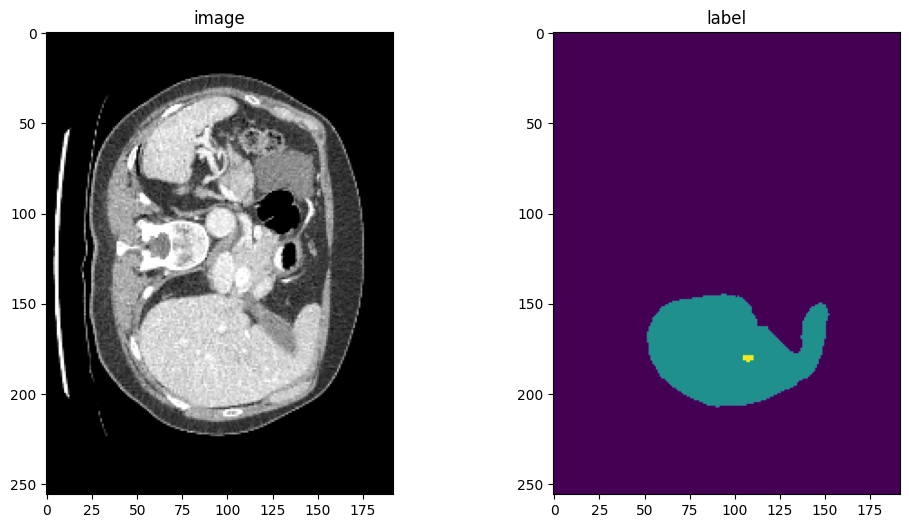

In [ ]:
check_ds = Dataset(data=train_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# for i in range(label.shape[2]):
#     if label[i].max() == 1:
#         k = random.randint(0,i)
# print(k)
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :,200 ], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 200])
plt.show()

In [ ]:
# check_ds = Dataset(data=val_files, transform=val_transforms)
# check_loader = DataLoader(check_ds, batch_size=1)
# check_data = first(check_loader)
# image, label = (check_data["image"][0][0], check_data["label"][0][0])
# print(f"image shape: {image.shape}, label shape: {label.shape}")
# # for i in range(label.shape[2]):
# #     if label[i].max() == 1:
# #         k = random.randint(0,i)
# # print(k)
# plt.figure("check", (12, 6))
# plt.subplot(1, 2, 1)
# plt.title("image")
# plt.imshow(image[:, :, 70], cmap="gray")
# plt.subplot(1, 2, 2)
# plt.title("label")
# plt.imshow(label[:, :, 70])
# plt.show()

In [ ]:
# Dataloaders - Train , val

#train
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=1 )
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1  )

#val
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=1)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=1 )

Loading dataset: 100%|██████████| 2/2 [00:27<00:00, 13.63s/it]


In [ ]:
data = first(train_loader)
data['image'].shape , data['label'].shape

(torch.Size([6, 1, 64, 64, 64]), torch.Size([6, 1, 64, 64, 64]))

In [ ]:
# !pip install git+https://github.com/bowang-lab/MedSAM.git

In [ ]:
# from transformers import SamModel, SamProcessor
# import torch
# device = torch.device('cuda')
# processor = SamProcessor.from_pretrained("wanglab/medsam-vit-base")
# model = SamModel.from_pretrained("wanglab/medsam-vit-base").to(device)

In [ ]:
import torch


device = torch.device("cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/liver_best_metric_model.pth' ,  map_location=torch.device('cpu')) )
loss_function = DiceCELoss(to_onehot_y=True, softmax=True )
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=True, reduction="mean")


In [ ]:
# def dice_metric(y_pred, y):
#     loss = DiceLoss(to_onehot_y=True, sigmoid=True , squared_pred = True)
#     value = 1-loss
#     return value


In [ ]:
# #loss / opt

# loss_function = DiceLoss(to_onehot_y=True, sigmoid=True)
# optimizer = torch.optim.Adam(model.parameters(), 1e-4)
# dice_metric = DiceMetric(include_background=True, reduction="mean")

In [ ]:
save_dir = '/content/drive/MyDrive/Models/2nd_stage_liver'

In [ ]:
torch.manual_seed(42)
max_epochs = 500
val_interval = 5
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True , to_onehot=3)])
post_label = Compose([AsDiscrete(to_onehot=3)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
      step += 1
      inputs, labels = (
          batch_data["image"].to(device),
          batch_data["label"].to(device),
      )
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()

#         print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    np.save(os.path.join(save_dir , 'liver_epoch_loss.npy') , epoch_loss_values)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.inference_mode():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (32, 32, 32)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model )
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
#                 print(val_labels.shape , val_outputs.shape)

                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                np.save(os.path.join(save_dir , 'liver_metric_values.npy') , metric_values)
                torch.save(model.state_dict(), os.path.join(HOME, "liver_best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/500
epoch 1 average loss: 0.5550
----------
epoch 2/500
epoch 2 average loss: 0.6127
----------
epoch 3/500
epoch 3 average loss: 0.5054
----------
epoch 4/500
epoch 4 average loss: 0.5201
----------
epoch 5/500
epoch 5 average loss: 0.4144
saved new best metric model
current epoch: 5 current mean dice: 0.7846
best mean dice: 0.7846 at epoch: 5
----------
epoch 6/500
epoch 6 average loss: 0.4251
----------
epoch 7/500
epoch 7 average loss: 0.5223
----------
epoch 8/500
epoch 8 average loss: 0.3833
----------
epoch 9/500
epoch 9 average loss: 0.5046
----------
epoch 10/500
epoch 10 average loss: 0.6084
saved new best metric model
current epoch: 10 current mean dice: 0.8066
best mean dice: 0.8066 at epoch: 10
----------
epoch 11/500
epoch 11 average loss: 0.3631
----------
epoch 12/500
epoch 12 average loss: 0.7639
----------
epoch 13/500
epoch 13 average loss: 0.4551
----------
epoch 14/500
epoch 14 average loss: 0.5394
----------
epoch 15/500
epoch 15 average loss: 0

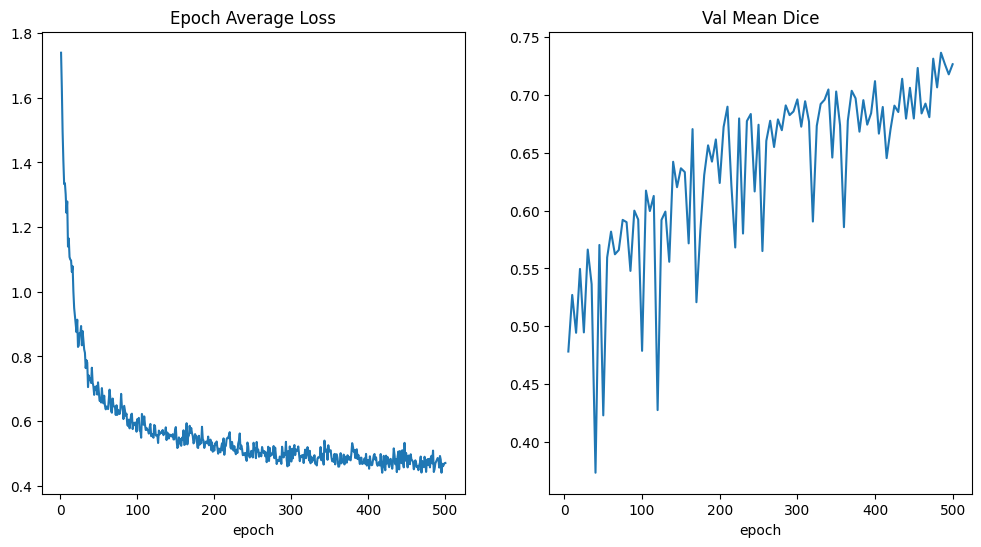

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

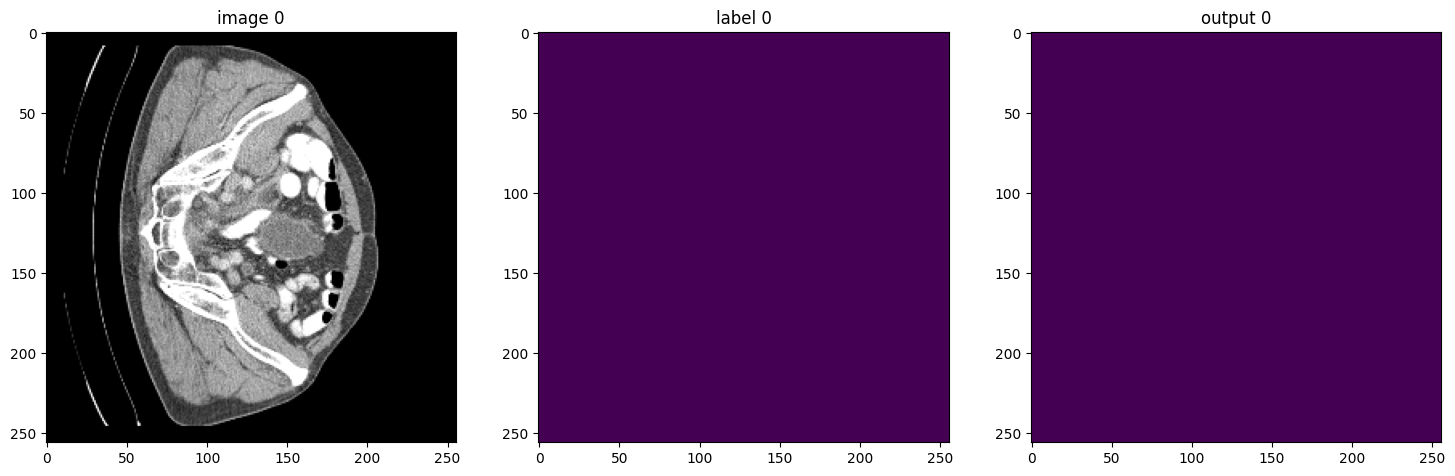

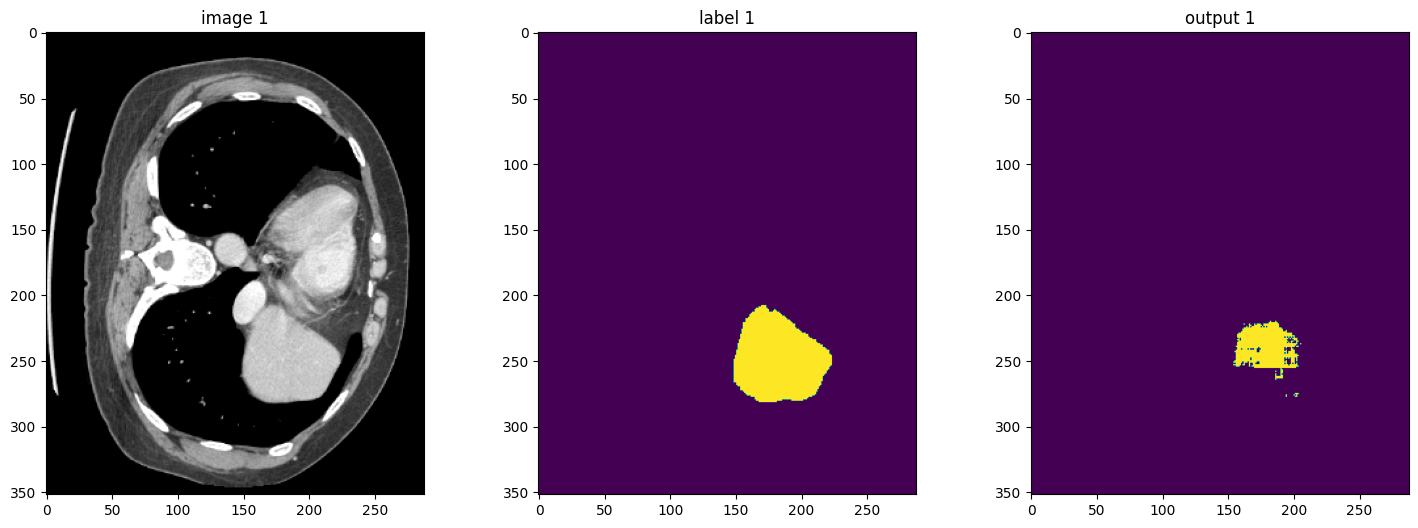

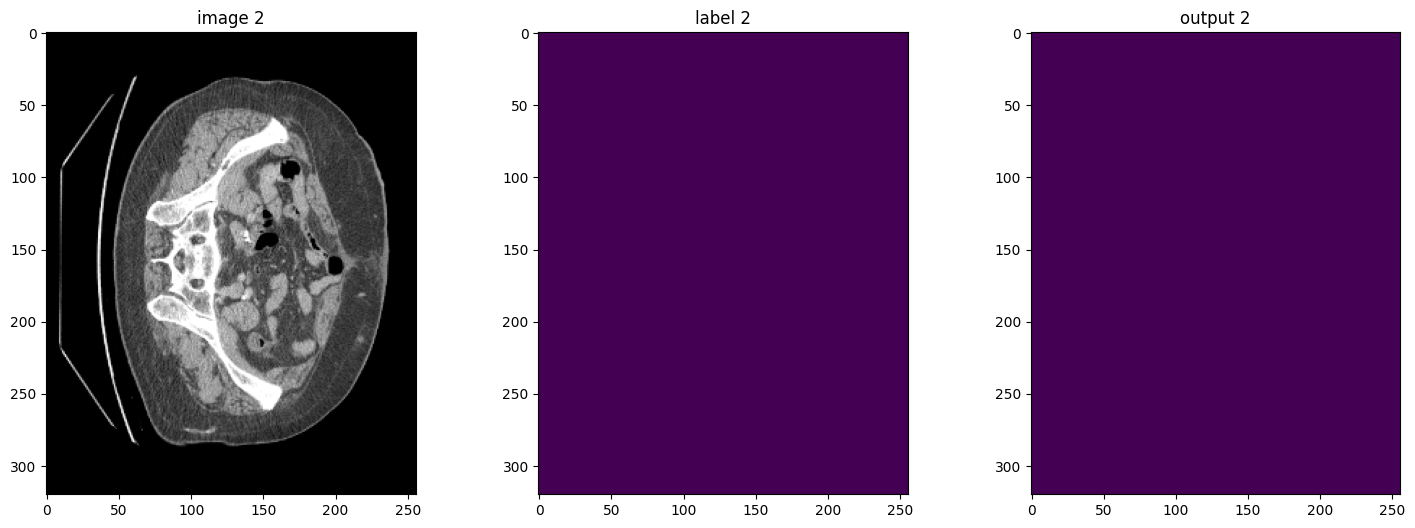

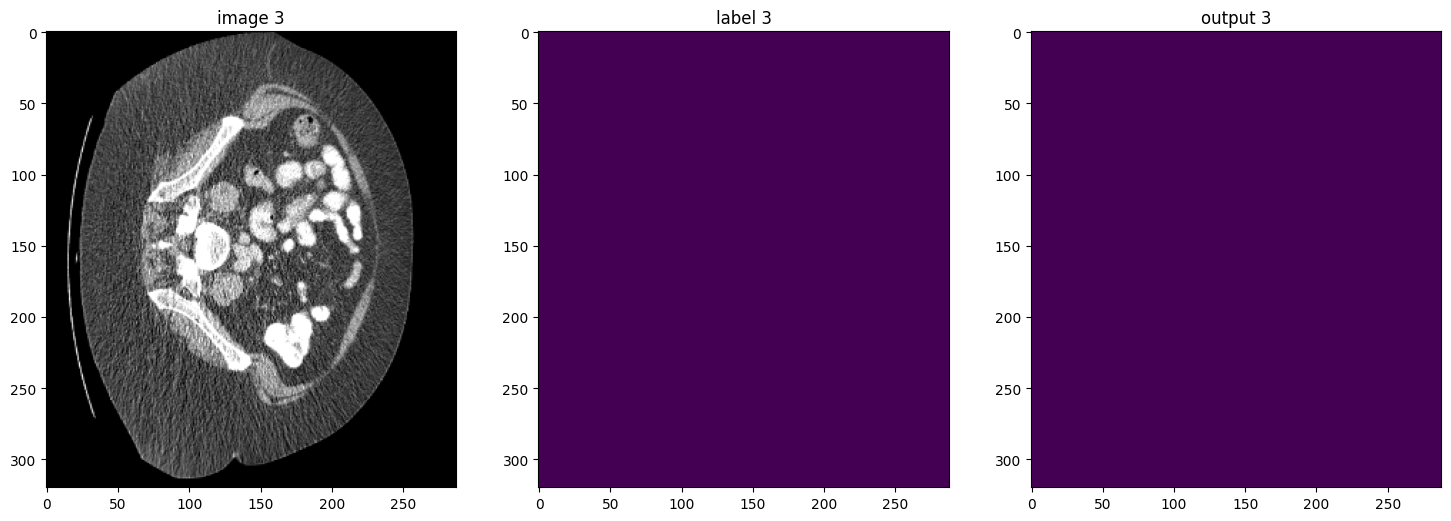

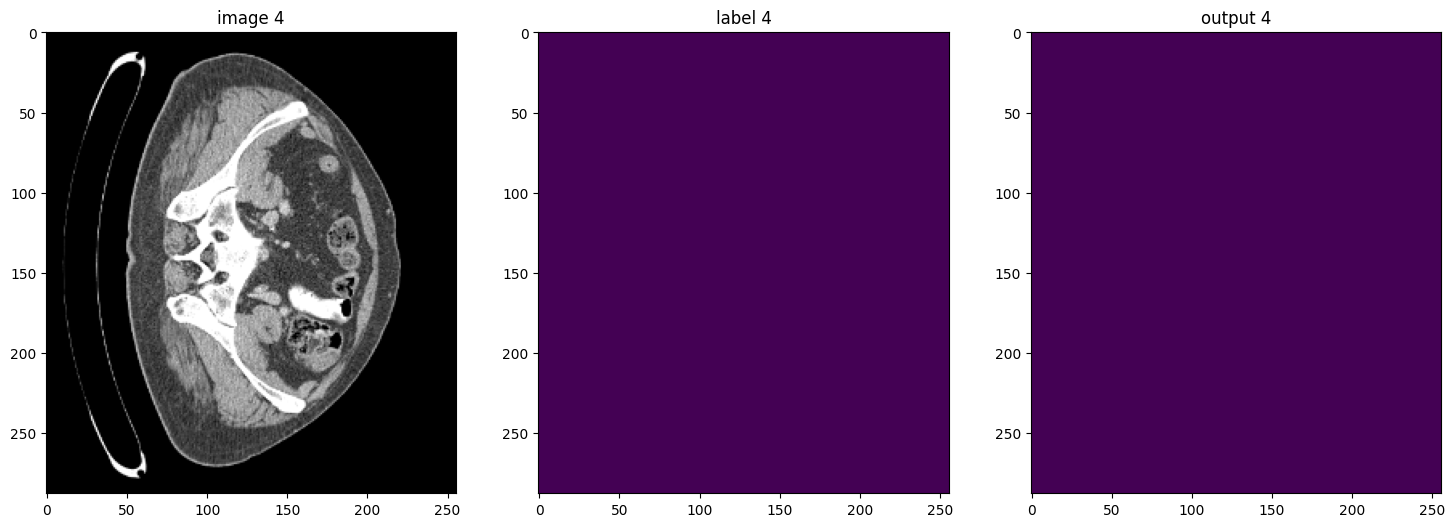

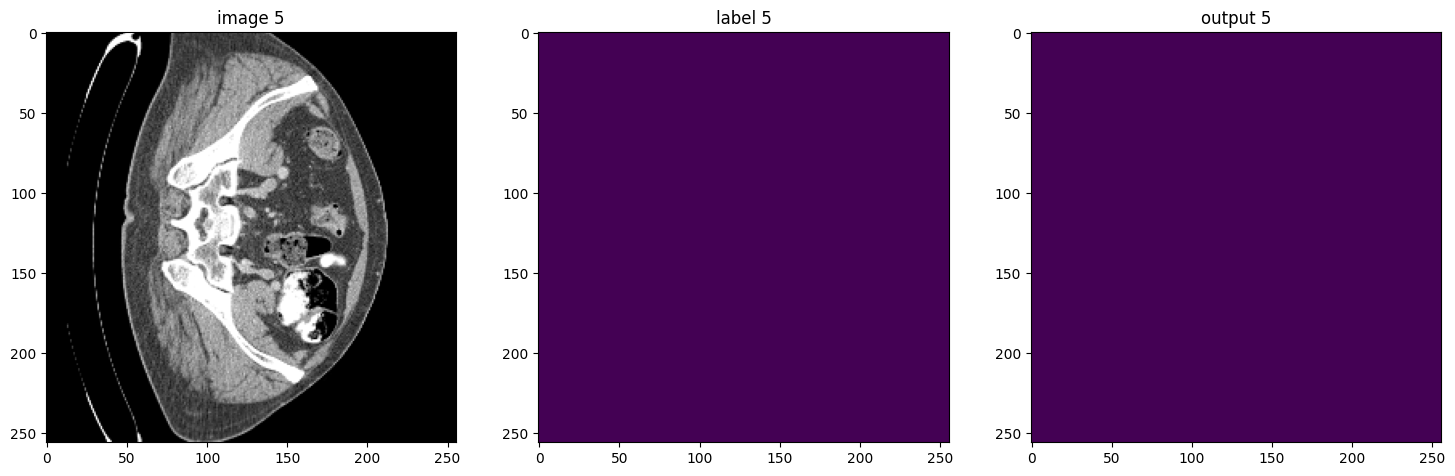

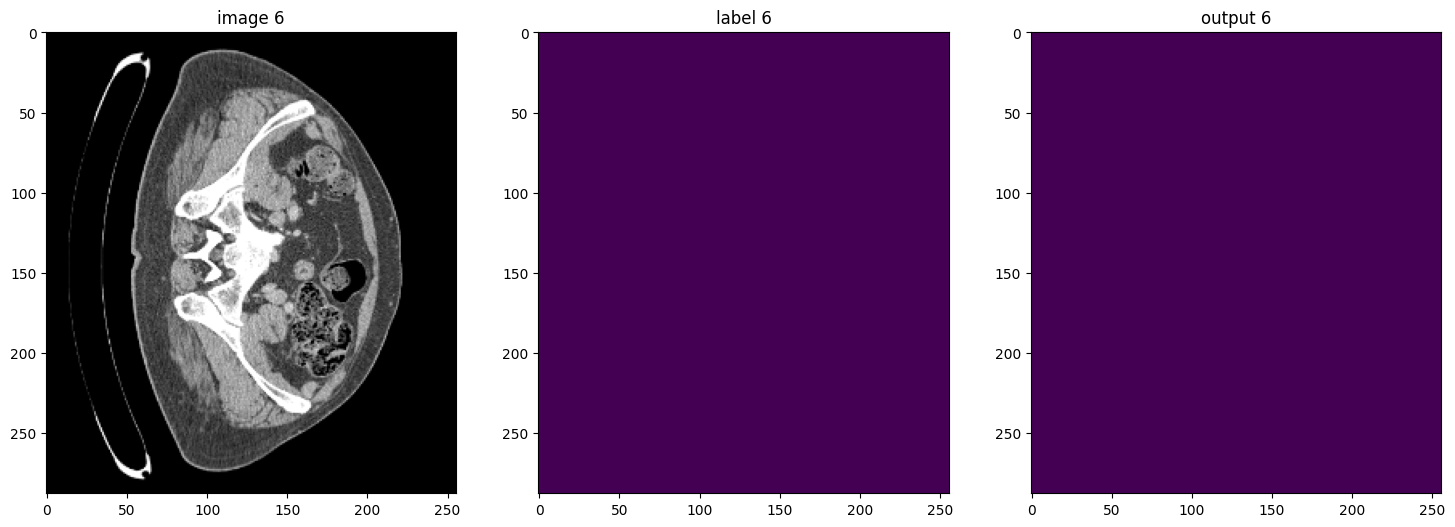

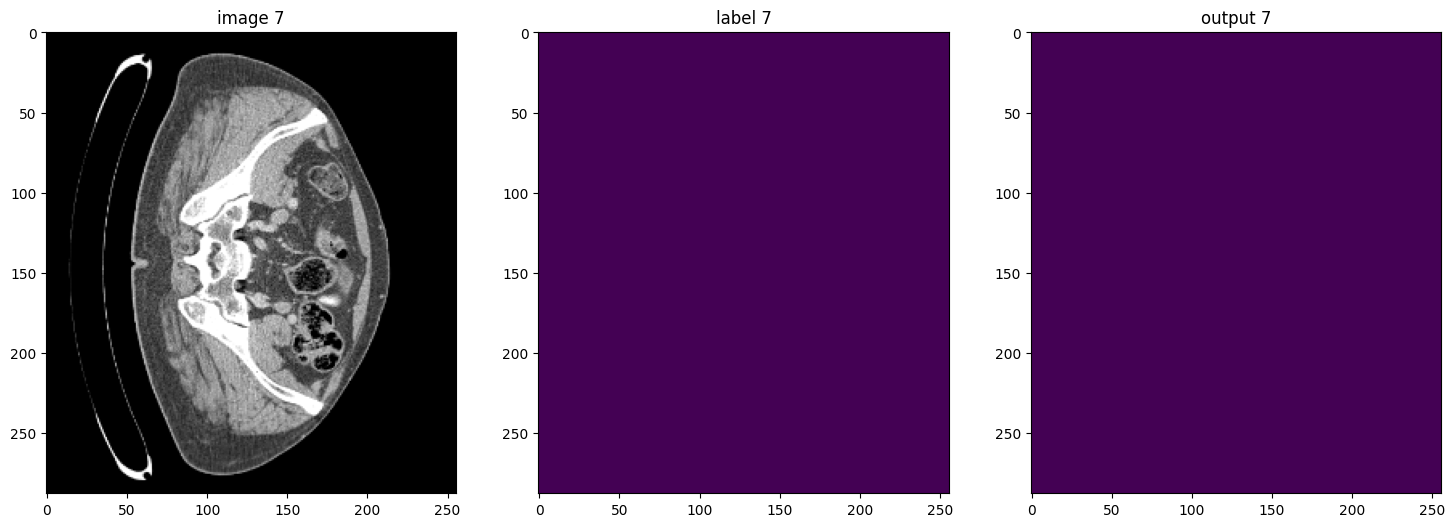

In [ ]:
model.load_state_dict(torch.load(os.path.join(HOME, "liver_best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (64, 64, 64)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
#         nib.save(val_data['image'].detach().cpu() , os.path.join(HOME ,f'image_ {i}_.nii.gz'))
#         nib.save(val_data['label'].detach().cpu() ,  os.path.join(HOME, f'label_{i}_.nii.gz'))



        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :,100], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 100])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 100])
        plt.show()
        #val_outputs = torch.softmax(val_outputs, 1).cpu().numpy()
        val_outputs = np.argmax(val_outputs, axis=1).astype(np.uint8)[0]
        nib.save(nib.Nifti1Image(val_outputs,val_data['image'][0,0,:,:,:].affine), os.path.join(save_dir, f'Model_Seg_{i}_.nii.gz'))

#         nib.save(val_data['image'] , filename = os.path.join('/content/drive/MyDrive/preds',f'image_ {i}_.nii.gz'))
#         nib.save(val_data['label'] , filename = os.path.join('/content/drive/MyDrive/preds', f'label_{i}_.nii.gz'))
#         nib.save(val_data['output'] , filename = os.path.join('/content/drive/MyDrive/preds',f'pred_{i}_.nii.gz'))
        if i == 10:
            break

In [ ]:
# torch.manual_seed(42)
# max_epochs = 200
# val_interval = 5
# best_metric = -1
# best_metric_epoch = -1
# epoch_loss_values = []
# metric_values = []
# post_pred = Compose([AsDiscrete(argmax=True , to_onehot=3)])
# post_label = Compose([AsDiscrete(to_onehot=3)])

# for epoch in range(max_epochs):
#     print("-" * 10)
#     print(f"epoch {epoch + 1}/{max_epochs}")
#     model.train()
#     epoch_loss = 0
#     step = 0
#     for batch_data in train_loader:
#         step += 1
#         inputs, labels = (
#             batch_data["image"].to(device),
#             batch_data["label"].to(device),
#         )
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = loss_function(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
# #         print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
#     epoch_loss /= step
#     epoch_loss_values.append(epoch_loss)
#     np.save(os.path.join(save_dir , 'liver_epoch_loss.npy') , epoch_loss_values)
#     print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

#     if (epoch + 1) % val_interval == 0:
#         model.eval()
#         with torch.inference_mode():
#             for val_data in val_loader:
#                 val_inputs, val_labels = (
#                     val_data["image"].to(device),
#                     val_data["label"].to(device),
#                 )
#                 roi_size = (32, 32, 32)
#                 sw_batch_size = 4
#                 val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model )
#                 val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
#                 val_labels = [post_label(i) for i in decollate_batch(val_labels)]
# #                 print(val_labels.shape , val_outputs.shape)

#                 # compute metric for current iteration
#                 dice_metric(y_pred=val_outputs, y=val_labels)

#             # aggregate the final mean dice result
#             metric = dice_metric.aggregate().item()
#             # reset the status for next validation round
#             dice_metric.reset()

#             metric_values.append(metric)
#             if metric > best_metric:
#                 best_metric = metric
#                 best_metric_epoch = epoch + 1
#                 np.save(os.path.join(save_dir , 'liver_metric_values.npy') , metric_values)
#                 torch.save(model.state_dict(), os.path.join(HOME, "liver_best_metric_model.pth"))
#                 print("saved new best metric model")
#             print(
#                 f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
#                 f"\nbest mean dice: {best_metric:.4f} "
#                 f"at epoch: {best_metric_epoch}"
#             )

In [ ]:
# import torchvision
# from torchvision.models.segmentation import fcn_resnet50 , FCN_ResNet50_Weights

In [ ]:
# weights = FCN_ResNet50_Weights.DEFAULT
# model2 = fcn_resnet50(weights = weights)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:01<00:00, 125MB/s]


In [ ]:
# max_epochs = 200
# val_interval = 2
# best_metric = -1
# best_metric_epoch = -1
# epoch_loss_values = []
# metric_values = []
# post_pred = Compose([AsDiscrete(argmax=True, to_onehot=3)])
# post_label = Compose([AsDiscrete(to_onehot=3)])

# for epoch in range(max_epochs):
#     print("-" * 10)
#     print(f"epoch {epoch + 1}/{max_epochs}")
#     model2.train()
#     epoch_loss = 0
#     step = 0
#     for batch_data in train_loader:
#         step += 1
#         inputs, labels = (
#             batch_data["image"].to(device),
#             batch_data["label"].to(device),
#         )
#         optimizer.zero_grad()
#         outputs = model2(inputs)
#         loss = loss_function(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
# #         print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
#     epoch_loss /= step
#     epoch_loss_values.append(epoch_loss)
#     print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

#     if (epoch + 1) % val_interval == 0:
#         model2.eval()
#         with torch.inference_mode():
#             for val_data in val_loader:
#                 val_inputs, val_labels = (
#                     val_data["image"].to(device),
#                     val_data["label"].to(device),
#                 )
#                 roi_size = (64, 64, 64)
#                 sw_batch_size = 1
#                 val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model2)
#                 val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
#                 val_labels = [post_label(i) for i in decollate_batch(val_labels)]
# #                 print(val_labels.shape , val_outputs.shape)

#                 # compute metric for current iteration
#                 dice_metric(y_pred=val_outputs, y=val_labels)

#             # aggregate the final mean dice result
#             metric = dice_metric.aggregate().item()
#             # reset the status for next validation round
#             dice_metric.reset()

#             metric_values.append(metric)
#             if metric > best_metric:
#                 best_metric = metric
#                 best_metric_epoch = epoch + 1
#                 torch.save(model2.state_dict(), os.path.join(HOME, "best_metric_model.pth"))
#                 print("saved new best metric model")
#             print(
#                 f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
#                 f"\nbest mean dice: {best_metric:.4f} "
#                 f"at epoch: {best_metric_epoch}"
#             )

----------
epoch 1/200


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [12, 1, 64, 64, 64]

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

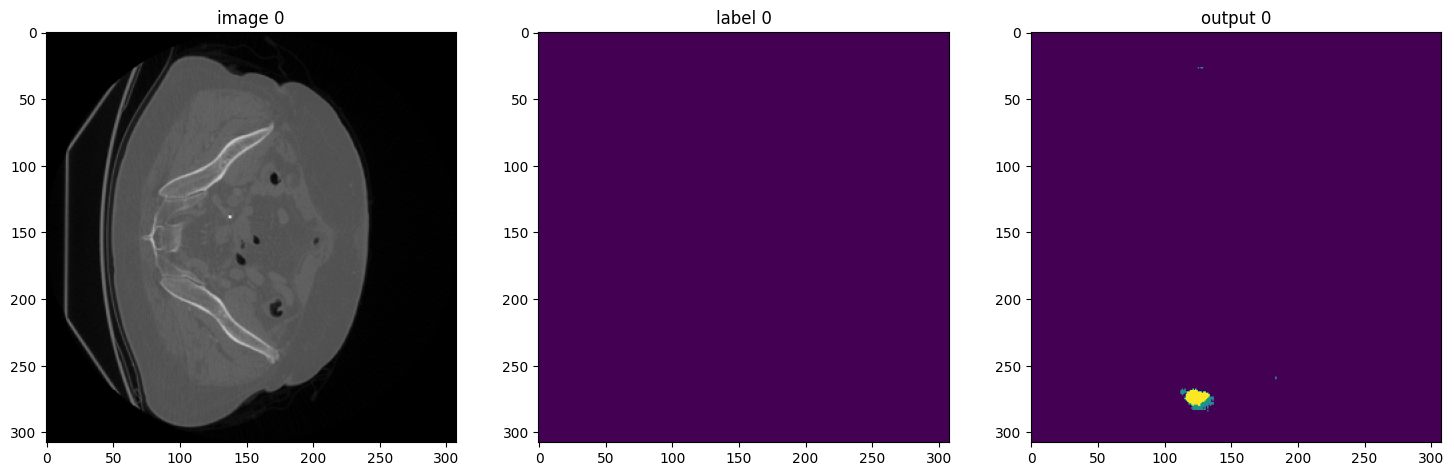

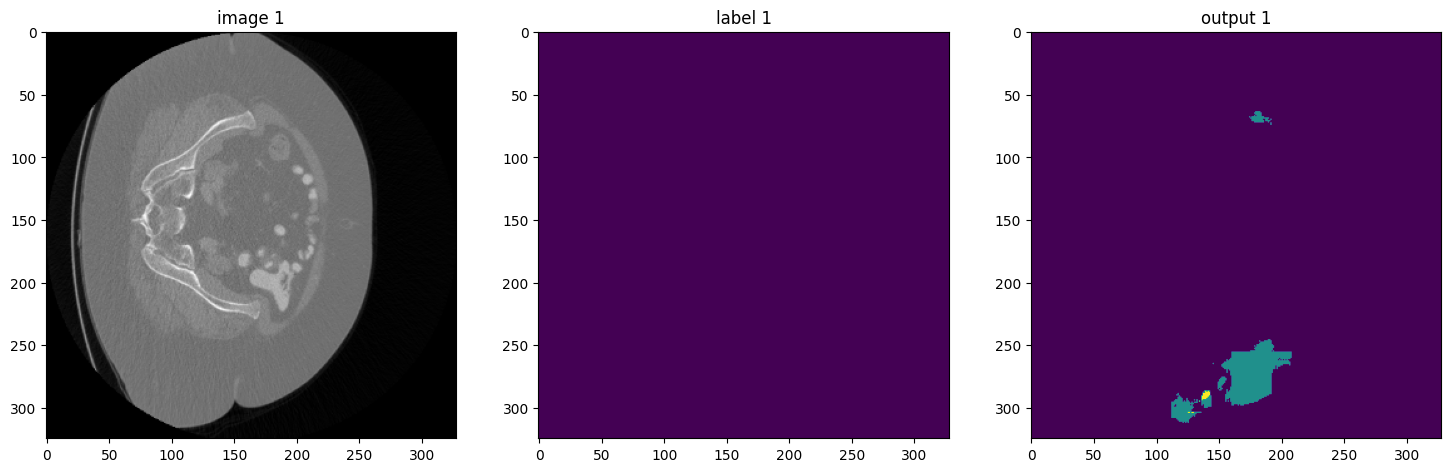

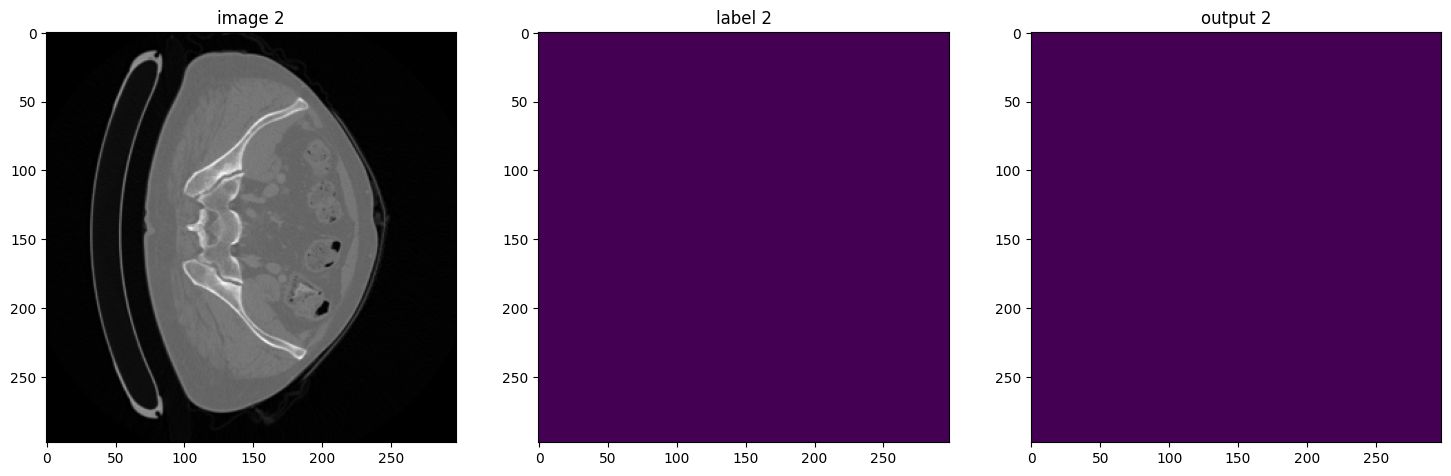

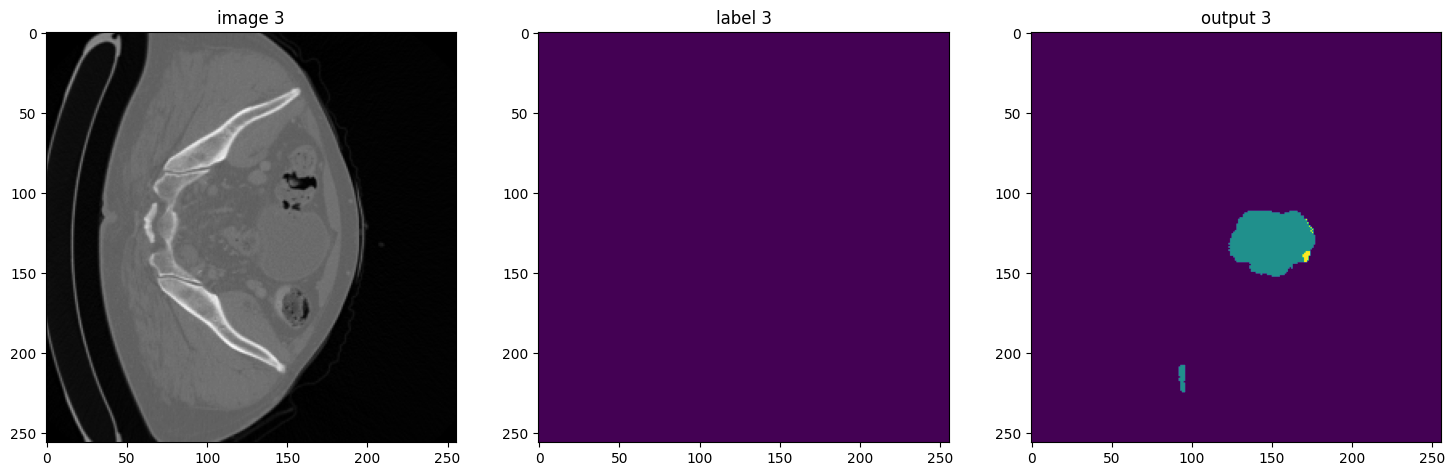

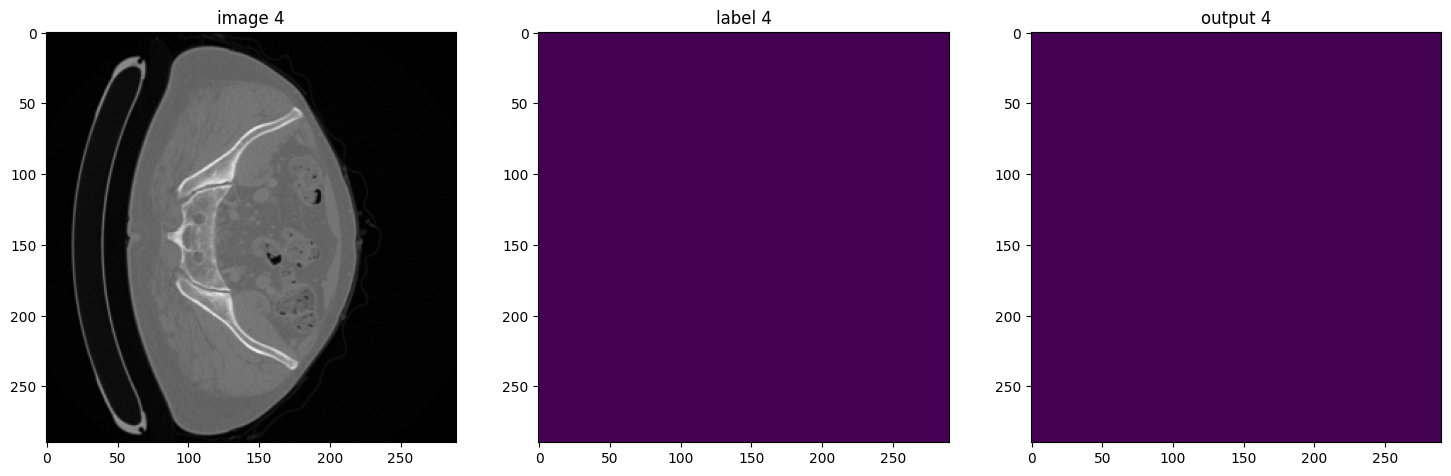

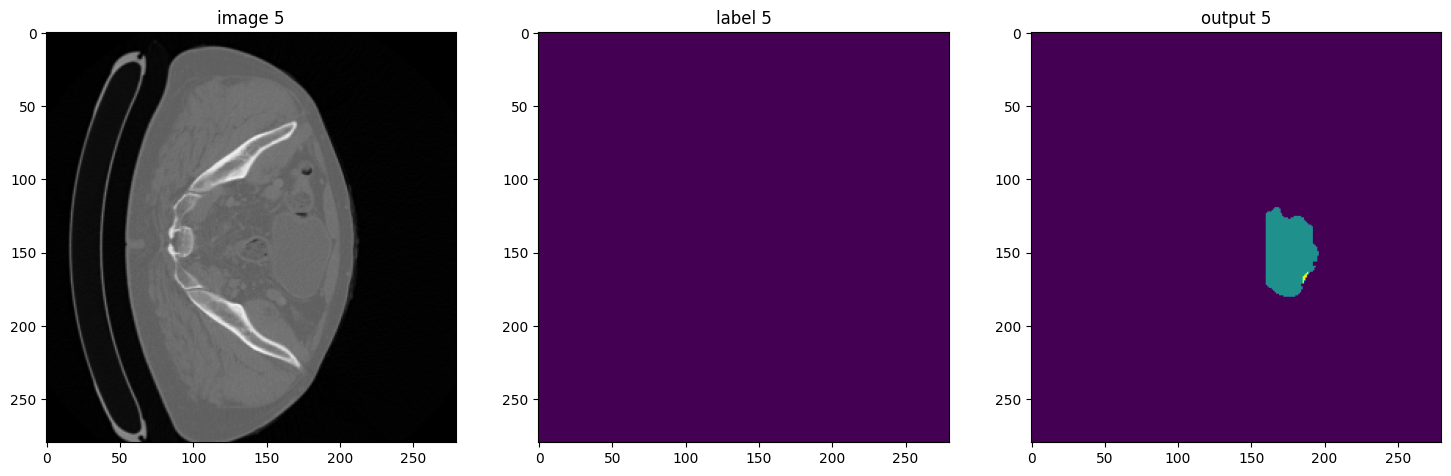

In [ ]:
model.load_state_dict(torch.load(os.path.join(HOME, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (64, 64, 64)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
#         nib.save(val_data['image'].detach().cpu() , os.path.join(HOME ,f'image_ {i}_.nii.gz'))
#         nib.save(val_data['label'].detach().cpu() ,  os.path.join(HOME, f'label_{i}_.nii.gz'))



        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :,80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        #val_outputs = torch.softmax(val_outputs, 1).cpu().numpy()
        val_outputs = np.argmax(val_outputs, axis=1).astype(np.uint8)[0]
        nib.save(nib.Nifti1Image(val_outputs,val_data['image'][0,0,:,:,:].affine), os.path.join(save_dir, f'predlabel_{i}_.nii.gz'))

#         nib.save(val_data['image'] , filename = os.path.join('/content/drive/MyDrive/preds',f'image_ {i}_.nii.gz'))
#         nib.save(val_data['label'] , filename = os.path.join('/content/drive/MyDrive/preds', f'label_{i}_.nii.gz'))
#         nib.save(val_data['output'] , filename = os.path.join('/content/drive/MyDrive/preds',f'pred_{i}_.nii.gz'))
        if i == 10:
            break

In [ ]:
(val_outputs.shape)

(308, 308, 337)

In [ ]:
val_outputs.shape[1]

308

In [ ]:
np.argmax(val_outputs)

5147752